In [ ]:
import glob
import numpy as np
import os
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
def get_data_from_fof_folder(output_dir, snapN, param1, param2):
    snapdir = glob.glob(output_dir+f"groups_*{snapN}")[0]
    snap_files = os.listdir(snapdir)
    
    all_values = None

    for file_name in snap_files:
        file_path = snapdir+f"/{file_name}"

        with h5py.File(file_path, "r") as f:
            values_this_file = f[f'{param1}/{param2}'][:]
            
            if all_values is None:
                all_values = values_this_file
            else:
                all_values = np.concatenate((all_values, values_this_file))
            
    
    return all_values

def get_data_from_snap_folder(output_dir, snapN, param1, param2):
    snapdir = glob.glob(output_dir+f"snapdir_*{snapN}")[0]
    snap_files = os.listdir(snapdir)
    # print(snap_files)
    
    all_values = None

    for file_name in snap_files:
        # print("-------------- File begin ----------------")
        file_path = snapdir+f"/{file_name}"
        # print(file_path)

        with h5py.File(file_path, "r") as f:
            # header = f['Header']
            # for key, val in header.attrs.items():
                # print(f"{key}: {val}")
            values_this_file = f[f'{param1}/{param2}'][:]
            
            if all_values is None:
                all_values = values_this_file
            else:
                all_values = np.concatenate((all_values, values_this_file))
            
            # print(values_this_file.shape)
            # print(all_values.shape)
        
        # print("--------------- File end ------------------")
    
    return all_values

def get_data_from_header(output_dir, snapN, param='BoxSize'):

    snapdir = glob.glob(output_dir+f"snapdir_*{snapN}")[0]
    snap_files = os.listdir(snapdir)
    file_name = snap_files[0]
    file_path = snapdir+f"/{file_name}"

    with h5py.File(file_path, "r") as f:
        header = f['Header']
        return_param = header.attrs[param]
        
    return return_param

In [ ]:
def get_subhalo_coords(path, snapN, particle_type="PartType4", zomm_in_box_size=500, resolution=128, look_for_centeral_bh_radius=500):
    subhalo_mass = get_data_from_fof_folder(path, snapN, "Subhalo", "SubhaloMass") * 1e10 # in M_sun

    index_biggeset_halo = max(range(len(subhalo_mass)), key=lambda i: subhalo_mass[i])
    bigges_subhalo = subhalo_mass[index_biggeset_halo]

    subhalo_cms = get_data_from_fof_folder(path, snapN, "Subhalo", "SubhaloCM")
    biggest_subhalo_cms = subhalo_cms[index_biggeset_halo]
    
    centeral_galaxy_bh = find_centeral_bh(path, snapN, biggest_subhalo_cms, look_for_centeral_bh_radius)

    boxsize = get_data_from_header(path, snapN, 'BoxSize') # in kpc
    
    # transform coordinates to center biggest_halo_cms
    coordinates = get_data_from_snap_folder(path, snapN, particle_type, "Coordinates")
    masses = get_data_from_snap_folder(path, snapN, particle_type, "Masses")*1e10 # in M_sun

    physical_bin_volume = (boxsize/resolution)**2 * boxsize/1e3  # this is a projection, so one axis has the full length of the box

    # transform to periodic coordinates centered around centeral_galaxy_bh
    cms_center_coordinates = coordinates - centeral_galaxy_bh
    cms_center_coordinates = (cms_center_coordinates + boxsize / 2) % boxsize - boxsize / 2
    
    masses = masses[cms_center_coordinates[:, 0] < zomm_in_box_size]
    cms_center_coordinates = cms_center_coordinates[cms_center_coordinates[:, 0] < zomm_in_box_size]
    masses = masses[cms_center_coordinates[:, 0] > -zomm_in_box_size]
    cms_center_coordinates = cms_center_coordinates[cms_center_coordinates[:, 0] > -zomm_in_box_size]
    masses = masses[cms_center_coordinates[:, 1] < zomm_in_box_size]
    cms_center_coordinates = cms_center_coordinates[cms_center_coordinates[:, 1] < zomm_in_box_size]
    masses = masses[cms_center_coordinates[:, 1] > -zomm_in_box_size]
    cms_center_coordinates = cms_center_coordinates[cms_center_coordinates[:, 1] > -zomm_in_box_size]
    masses = masses[cms_center_coordinates[:, 2] < zomm_in_box_size]
    cms_center_coordinates = cms_center_coordinates[cms_center_coordinates[:, 2] < zomm_in_box_size]
    masses = masses[cms_center_coordinates[:, 2] > -zomm_in_box_size]
    cms_center_coordinates = cms_center_coordinates[cms_center_coordinates[:, 2] > -zomm_in_box_size]
    
    return cms_center_coordinates, masses

In [ ]:
def find_centeral_bh(path, snapN, zoom_in_box_middle, zoom_in_box_size):
    particle_type = "PartType5"
    coordinates = get_data_from_snap_folder(path, snapN, particle_type, "Coordinates")
    boxsize = get_data_from_header(path, snapN, 'BoxSize') # in kpc
    
    # transform into periodic box with center at zoom_in_box_middle
    center_coordinates = (coordinates - zoom_in_box_middle + boxsize / 2) % boxsize - boxsize / 2
    
    # only look at objects within a box centered around 0 with zoom_in_box_size as length, heigt and width 
    center_coordinates = center_coordinates[center_coordinates[:, 0] < zoom_in_box_size]
    center_coordinates = center_coordinates[center_coordinates[:, 0] > -zoom_in_box_size]
    center_coordinates = center_coordinates[center_coordinates[:, 1] < zoom_in_box_size]
    center_coordinates = center_coordinates[center_coordinates[:, 1] > -zoom_in_box_size]
    center_coordinates = center_coordinates[center_coordinates[:, 2] < zoom_in_box_size]
    center_coordinates = center_coordinates[center_coordinates[:, 2] > -zoom_in_box_size]
    
    # center_coordinates is ordered by mass, so center_coordinates[0] is the most massive BH in the box
    # then transform back to original coordinates
    centeral_bh_coords = (center_coordinates[0] + zoom_in_box_middle + boxsize / 2) % boxsize - boxsize / 2
    
    return centeral_bh_coords

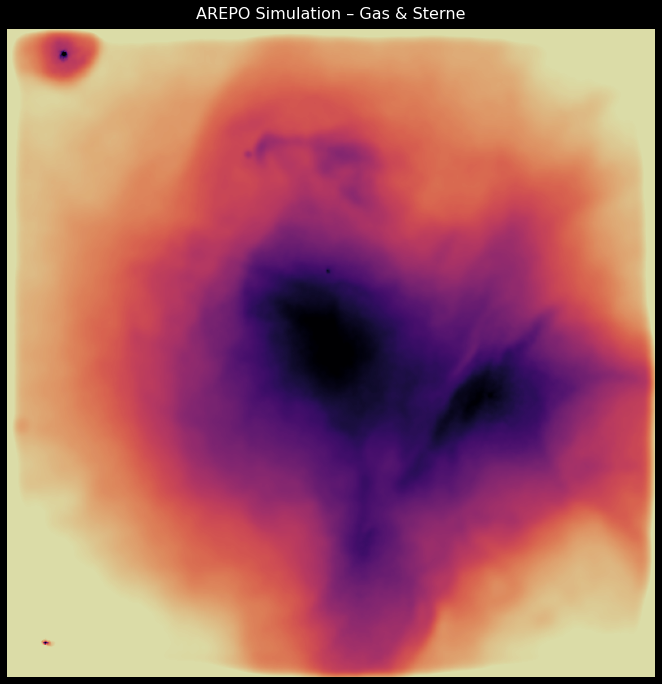

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import sphviewer as sph
from matplotlib.colors import LogNorm

# ==========================
# 🔹 Parameter
# ==========================
boxsize = 500    # in denselben Einheiten wie deine Koordinaten (z.B. kpc)
camera_zoom = 1
path = "/vera/u/jerbo/my_ptmp/L25n256_suite/gridpoint1/"

# ==========================
# 🔹 Daten laden (Koordinaten & Masse)
# ==========================
star_coords, star_mass = get_subhalo_coords(path, snapN=5, particle_type="PartType4",
                                            zomm_in_box_size=500, look_for_centeral_bh_radius=300)
gas_coords, gas_mass = get_subhalo_coords(path, snapN=5, particle_type="PartType0",
                                          zomm_in_box_size=500, look_for_centeral_bh_radius=300)

# ==========================
# 🔹 Gasrendering mit SPHViewer
# ==========================
gas_particles = sph.Particles(gas_coords, mass=gas_mass)
scene = sph.Scene(gas_particles)
scene.update_camera(r='infinity', x=0, y=0, z=boxsize / 2)
render = sph.Render(scene)
gas_img = render.get_image()

# ==========================
# 🔹 Gasbild aufbereiten (Kontrast + Colormap)
# ==========================
gas_img_log = np.log10(gas_img + 1e-8)
vmin, vmax = np.percentile(gas_img_log, [10, 99.7])  # Kontrastbereich

extent = [-boxsize/2, boxsize/2, -boxsize/2, boxsize/2]  # physikalische Skala

# ==========================
# 🔹 Plot
# ==========================
fig, ax = plt.subplots(figsize=(9, 9))

# Gas-Layer
ax.imshow(gas_img_log, origin='lower', cmap='magma_r',
          vmin=vmin, vmax=vmax, extent=extent, alpha=0.88)

# Sterne-Layer (mehrere Scatter für Glow)
# ax.scatter(star_coords[:,0], star_coords[:,1], s=3, c='white', alpha=0.95, lw=0)
#ax.scatter(star_coords[:,0], star_coords[:,1], s=8, c='aqua', alpha=0.2, lw=0)
#ax.scatter(star_coords[:,0], star_coords[:,1], s=15, c='deepskyblue', alpha=0.05, lw=0)

# ==========================
# 🔹 Layout
# ==========================
ax.set_xlim(-boxsize/2, boxsize/2)
ax.set_ylim(-boxsize/2, boxsize/2)
ax.set_aspect('equal', 'box')
ax.axis('off')

fig.patch.set_facecolor('black')
ax.set_facecolor('black')
ax.set_title("AREPO Simulation – Gas & Sterne", fontsize=16, color='white', pad=10)

fig.subplots_adjust(0, 0, 1, 1)
# plt.savefig("arepo_render_final.png", dpi=400,
#             bbox_inches='tight', pad_inches=0, facecolor='black')
plt.show()